In [1]:
# Install dependencies in Colab
!pip install pandas numpy scikit-learn matplotlib seaborn xgboost lightgbm tensorflow keras streamlit optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 80.9 MB/s eta 0:00:00


In [10]:
# ========================
# STEP 1: Import Libraries
# ========================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


In [5]:
#dataset load
import pandas as pd

# Adjust path to your dataset
df = pd.read_csv('/content/coin_gecko_2022-03-17.csv')
df.head()


,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date
0,Bitcoin,BTC,40851.380000,0.001,0.000,-0.027,2.047612e+10,7.760774e+11,2022-03-17
1,Ethereum,ETH,2824.420000,0.004,0.029,0.034,1.364041e+10,3.390772e+11,2022-03-17
2,Tether,USDT,1.000000,-0.000,0.000,0.000,4.413140e+10,8.020588e+10,2022-03-17
3,BNB,BNB,389.610000,0.002,0.016,-0.010,1.425354e+09,6.556116e+10,2022-03-17
4,USD Coin,USDC,0.999739,-0.001,0.000,-0.000,3.569816e+09,5.259607e+10,2022-03-17


In [8]:
# ========================
# STEP 3: Explore Dataset
# ========================
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())

# Show info about data types and missing values
df.info()

# Summary statistics
df.describe()


Shape of dataset: (500, 9)

Columns: ['coin', 'symbol', 'price', '1h', '24h', '7d', '24h_volume', 'mkt_cap', 'date']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   coin        500 non-null    object 
 1   symbol      500 non-null    object 
 2   price       500 non-null    float64
 3   1h          500 non-null    float64
 4   24h         500 non-null    float64
 5   7d          500 non-null    float64
 6   24h_volume  500 non-null    float64
 7   mkt_cap     500 non-null    float64
 8   date        500 non-null    object 
dtypes: float64(6), object(3)
memory usage: 35.3+ KB


,price,1h,24h,7d,24h_volume,mkt_cap
count,5.000000e+02,500.000000,500.000000,500.000000,5.000000e+02,5.000000e+02
mean,6.594269e+02,0.000710,0.018508,0.007752,2.490462e+08,3.787932e+09
std,4.595355e+03,0.033003,0.059929,0.251303,2.276862e+09,3.826905e+10
min,1.484000e-09,-0.704000,-0.646000,-0.558000,4.349000e+01,6.731896e+07
25%,2.043850e-01,-0.001000,0.000000,-0.051000,1.727756e+06,1.194822e+08
50%,1.100000e+00,0.001000,0.011000,-0.015000,7.834438e+06,2.168525e+08
75%,7.435000e+00,0.004000,0.030000,0.020000,3.638643e+07,6.091268e+08
max,4.090907e+04,0.095000,0.577000,4.608000,4.413140e+10,7.760774e+11


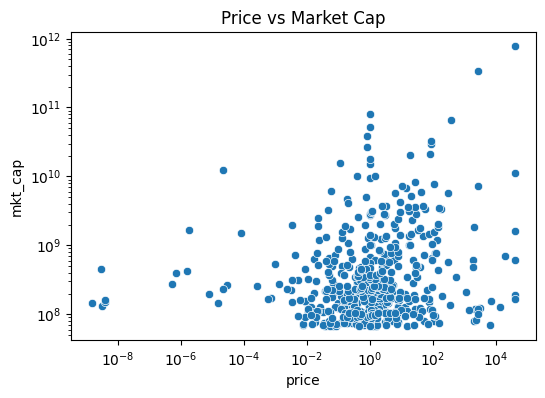

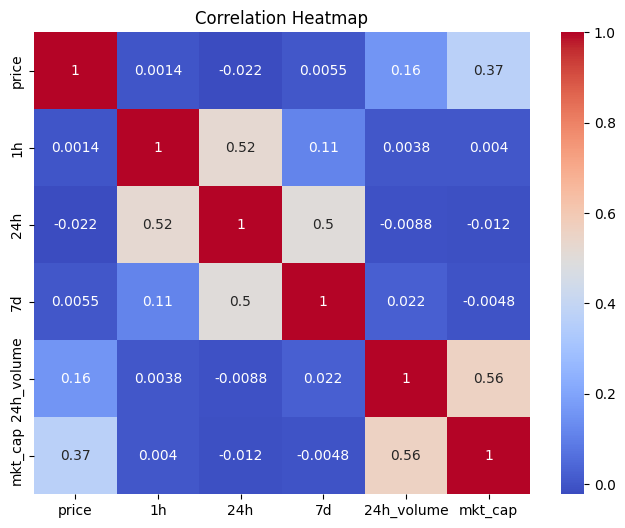

In [11]:
# ========================
# STEP 4: Basic EDA (Plots)
# ========================

# Price vs Market Cap (log scale for better view)
plt.figure(figsize=(6,4))
sns.scatterplot(x=df['price'], y=df['mkt_cap'])
plt.xscale('log')
plt.yscale('log')
plt.title("Price vs Market Cap")
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


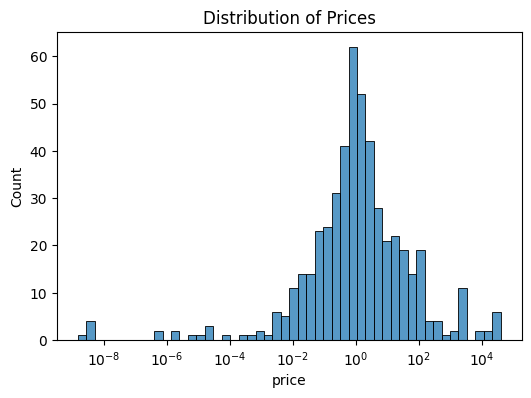

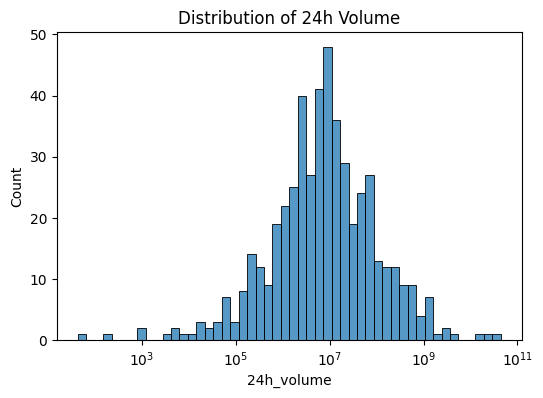

               coin  liquidity_ratio
13        Kishu Inu     3.996208e+15
469  Baby Doge Coin     3.473637e+15
61        FEG Token     1.606196e+14
103   FEG Token BSC     6.939199e+13
59     Bezoge Earth     5.907172e+13
274      BitTorrent     3.946412e+13
493          APENFT     3.436735e+13
326       Shiba Inu     1.949959e+13
487    Dogelon Mars     1.128353e+13
74       UFO Gaming     7.306600e+11


In [17]:
# Histogram of Prices
plt.figure(figsize=(6,4))
sns.histplot(df['price'], bins=50, log_scale=True)
plt.title("Distribution of Prices")
plt.show()

# Trading Volume Distribution
plt.figure(figsize=(6,4))
sns.histplot(df['24h_volume'], bins=50, log_scale=True)
plt.title("Distribution of 24h Volume")
plt.show()

# Top 10 Coins by Liquidity Ratio (volume/price)
df['liquidity_ratio'] = df['24h_volume'] / (df['price'].replace(0,1))
top10 = df[['coin','liquidity_ratio']].sort_values(by='liquidity_ratio', ascending=False).head(10)
print(top10)


In [12]:
# ========================
# STEP 5: Preprocessing
# ========================
# Features (independent variables)
features = ['price', '1h', '24h', '7d', '24h_volume']
X = df[features]

# Target (dependent variable we want to predict)
y = df['mkt_cap']

# Handle missing values (if any)
X = X.fillna(0)
y = y.fillna(0)

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (important for ML models)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [14]:
# ========================
# STEP 6: Train Models
# ========================

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    return rmse, mae, r2

# ---- Linear Regression ----
lr = LinearRegression().fit(X_train_s, y_train)
print("Linear Regression:", evaluate_model(lr, X_test_s, y_test))

# ---- Random Forest ----
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_s, y_train)
print("Random Forest:", evaluate_model(rf, X_test_s, y_test))

# ---- XGBoost ----
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train_s, y_train)
print("XGBoost:", evaluate_model(xgb, X_test_s, y_test))


Linear Regression: (4.772142923556165e+21, 9117408184.964115, 0.2016662615264685)
Random Forest: (3.688254348799623e+21, 7146212884.6603, 0.3829904238232086)
XGBoost: (1.9224376591164333e+21, 5563604802.26375, 0.6783946189438423)


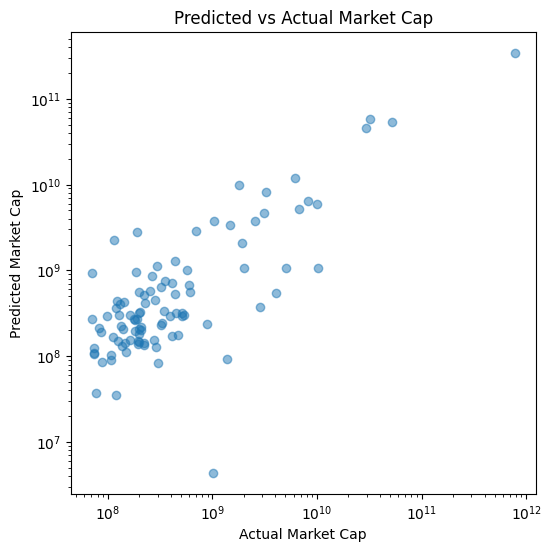

In [15]:
# ========================
# STEP 7: Visualize Predictions
# ========================

preds = xgb.predict(X_test_s)   # use best model (XGBoost)

plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("Actual Market Cap")
plt.ylabel("Predicted Market Cap")
plt.title("Predicted vs Actual Market Cap")
plt.xscale("log")
plt.yscale("log")
plt.show()


In [19]:
import pandas as pd

results = {
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [
        mean_squared_error(y_test, lr.predict(X_test_s)),
        mean_squared_error(y_test, rf.predict(X_test_s)),
        mean_squared_error(y_test, xgb.predict(X_test_s)),
    ],
    "MAE": [
        mean_absolute_error(y_test, lr.predict(X_test_s)),
        mean_absolute_error(y_test, rf.predict(X_test_s)),
        mean_absolute_error(y_test, xgb.predict(X_test_s)),
    ],
    "R2 Score": [
        r2_score(y_test, lr.predict(X_test_s)),
        r2_score(y_test, rf.predict(X_test_s)),
        r2_score(y_test, xgb.predict(X_test_s)),
    ]
}

results_df = pd.DataFrame(results)
results_df


,Model,RMSE,MAE,R2 Score
0,Linear Regression,4.772143e+21,9.117408e+09,0.201666
1,Random Forest,3.688254e+21,7.146213e+09,0.382990
2,XGBoost,1.922438e+21,5.563605e+09,0.678395


In [20]:
# ========================
# STEP 8: Save Model
# ========================
joblib.dump(xgb, "crypto_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and Scaler saved!")


✅ Model and Scaler saved!
